In [49]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.utils import to_categorical
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Imputer, MinMaxScaler, LabelBinarizer, LabelEncoder
from keras.utils import to_categorical

%matplotlib inline

In [2]:
def data_titanic_processing(data):
    # retirando dados desnecessários e divindo dados e labels
    data.drop(labels=['Name', 'Ticket', 'PassengerId'],axis=1, inplace=True)
    data = data.dropna()
    data_x, data_y = data.drop(labels='Survived', axis=1), data['Survived']
    data_y = np.array(data_y).reshape(-1,1)
    
    # Tratando dados númericos e categoricos
    data_x_numerical = data_x.drop(labels=['Sex', 'Cabin', 'Embarked'], axis=1)
    scaler = MinMaxScaler(feature_range=(0,1))
    data_x_numerical[['Age', 'Fare']] = scaler.fit_transform(data_x_numerical[['Age', 'Fare']])
    data_x_categorical = data_x[['Sex', 'Cabin', 'Embarked']]
    binarizer = LabelBinarizer()
    encoder = LabelEncoder()
    data_x_categorical['Sex'] = binarizer.fit_transform(data_x_categorical['Sex'])
    data_x_categorical['Cabin'] = encoder.fit_transform(data_x_categorical['Cabin'])
    data_x_categorical['Cabin'] = scaler.fit_transform(data_x_categorical['Cabin'].reshape(-1,1))
    data_x_categorical['Embarked'] = encoder.fit_transform(data_x_categorical['Embarked'])
    
    # Merge dos dados categoricos e númericos tratados
    data_x_categorical = data_x_categorical.reset_index()
    data_x_numerical = data_x_numerical.reset_index()
    data_tr = data_x_categorical.merge(data_x_numerical, on='index')
    data_tr.drop(['index'], axis=1, inplace=True)
    
    return data_tr, data_y
    
    

In [67]:
def data_test_titanic_processing(data):
    # retirando dados desnecessários e divindo dados e labels
    data.drop(labels=['name', 'ticket', 'boat', 'body', 'home.dest'],axis=1, inplace=True)
    data = data.dropna()
    data_x, data_y = data.drop(labels='survived', axis=1), data['survived']
    data_y = np.array(data_y).reshape(-1,1)
    
    # Tratando dados númericos e categoricos
    data_x_numerical = data_x.drop(labels=['sex', 'cabin', 'embarked'], axis=1)
    scaler = MinMaxScaler(feature_range=(0,1))
    data_x_numerical[['age', 'fare']] = scaler.fit_transform(data_x_numerical[['age', 'fare']])
    data_x_categorical = data_x[['sex', 'cabin', 'embarked']]
    binarizer = LabelBinarizer()
    encoder = LabelEncoder()
    data_x_categorical['sex'] = binarizer.fit_transform(data_x_categorical['sex'])
    data_x_categorical['cabin'] = encoder.fit_transform(data_x_categorical['cabin'])
    data_x_categorical['cabin'] = scaler.fit_transform(data_x_categorical['cabin'].reshape(-1,1))
    data_x_categorical['embarked'] = encoder.fit_transform(data_x_categorical['embarked'])
    
    # Merge dos dados categoricos e númericos tratados
    data_x_categorical = data_x_categorical.reset_index()
    data_x_numerical = data_x_numerical.reset_index()
    data_tr = data_x_categorical.merge(data_x_numerical, on='index')
    data_tr.drop(['index'], axis=1, inplace=True)
    
    return data_tr, data_y
    

In [72]:
data_test = pd.read_excel('dataset/titanic3.xls')
data_test_x, data_test_y = data_test_titanic_processing(data_test)

D:\Programas\Anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
D:\Programas\Anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
D:\Programas\Anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
D:\Programas\A

In [73]:
data = pd.read_csv('dataset/train.csv')
data_x, data_y = data_titanic_processing(data)

D:\Programas\Anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
D:\Programas\Anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
D:\Programas\Anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
D:\Programas\A

data_train_x, data_test_x, data_train_y, data_test_y = train_test_split(data_x, data_y, test_size=83, random_state=42)
data_train_x.shape, data_test_x.shape, data_train_y.shape, data_test_y.shape

In [70]:
data_y_oh, data_test_y_oh = to_categorical(data_y, 2), to_categorical(data_test_y, 2)
data_test_x.shape

(270, 8)

In [79]:
D_in, D_out = data_train_x.shape[1], data_train_x.shape[0]
model = Sequential()
model.add(Dense(units=D_in, activation='linear', input_shape=(data_x.shape[1],)))
model.add(Dense(units=30, activation='tanh'))
model.add(Dense(units=30, activation='tanh'))
model.add(Dense(units=20, activation='tanh'))
model.add(Dense(units=2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['accuracy'])
print(model.summary())
history = model.fit(x=data_x, y=data_y_oh, epochs=1000, verbose=1, validation_data=(data_test_x, data_test_y_oh))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_179 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_180 (Dense)            (None, 30)                270       
_________________________________________________________________
dense_181 (Dense)            (None, 30)                930       
_________________________________________________________________
dense_182 (Dense)            (None, 20)                620       
_________________________________________________________________
dense_183 (Dense)            (None, 2)                 42        
Total params: 1,934
Trainable params: 1,934
Non-trainable params: 0
_________________________________________________________________
None
Train on 183 samples, validate on 270 samples
Epoch 1/1000
183/183 [==============================] - 1s 8ms/step - loss: 0.6544 - acc:

183/183 [==============================] - 0s 252us/step - loss: 0.4419 - acc: 0.7541 - val_loss: 0.4455 - val_acc: 0.7407
Epoch 54/1000
183/183 [==============================] - 0s 247us/step - loss: 0.4426 - acc: 0.7541 - val_loss: 0.4410 - val_acc: 0.7815
Epoch 55/1000
183/183 [==============================] - 0s 296us/step - loss: 0.4400 - acc: 0.7760 - val_loss: 0.4402 - val_acc: 0.7778
Epoch 56/1000
183/183 [==============================] - 0s 290us/step - loss: 0.4415 - acc: 0.7760 - val_loss: 0.4414 - val_acc: 0.7778
Epoch 57/1000
183/183 [==============================] - 0s 315us/step - loss: 0.4390 - acc: 0.7705 - val_loss: 0.4428 - val_acc: 0.7704
Epoch 58/1000
183/183 [==============================] - 0s 274us/step - loss: 0.4395 - acc: 0.7650 - val_loss: 0.4393 - val_acc: 0.7852
Epoch 59/1000
183/183 [==============================] - 0s 304us/step - loss: 0.4393 - acc: 0.7705 - val_loss: 0.4384 - val_acc: 0.7926
Epoch 60/1000
183/183 [==============================] 

Epoch 113/1000
183/183 [==============================] - 0s 334us/step - loss: 0.4235 - acc: 0.7869 - val_loss: 0.4315 - val_acc: 0.7815
Epoch 114/1000
183/183 [==============================] - 0s 296us/step - loss: 0.4228 - acc: 0.7760 - val_loss: 0.4331 - val_acc: 0.7778
Epoch 115/1000
183/183 [==============================] - 0s 289us/step - loss: 0.4244 - acc: 0.7705 - val_loss: 0.4326 - val_acc: 0.7778
Epoch 116/1000
183/183 [==============================] - 0s 299us/step - loss: 0.4230 - acc: 0.7869 - val_loss: 0.4302 - val_acc: 0.7963
Epoch 117/1000
183/183 [==============================] - 0s 296us/step - loss: 0.4265 - acc: 0.7760 - val_loss: 0.4301 - val_acc: 0.7963
Epoch 118/1000
183/183 [==============================] - 0s 299us/step - loss: 0.4259 - acc: 0.7760 - val_loss: 0.4441 - val_acc: 0.7704
Epoch 119/1000
183/183 [==============================] - 0s 312us/step - loss: 0.4298 - acc: 0.7596 - val_loss: 0.4300 - val_acc: 0.7963
Epoch 120/1000
183/183 [==========

183/183 [==============================] - ETA: 0s - loss: 0.4309 - acc: 0.718 - 0s 238us/step - loss: 0.4111 - acc: 0.7814 - val_loss: 0.4247 - val_acc: 0.7815
Epoch 173/1000
183/183 [==============================] - 0s 258us/step - loss: 0.4138 - acc: 0.7978 - val_loss: 0.4235 - val_acc: 0.7852
Epoch 174/1000
183/183 [==============================] - 0s 260us/step - loss: 0.4077 - acc: 0.7978 - val_loss: 0.4229 - val_acc: 0.7926
Epoch 175/1000
183/183 [==============================] - 0s 255us/step - loss: 0.4145 - acc: 0.7869 - val_loss: 0.4237 - val_acc: 0.7852
Epoch 176/1000
183/183 [==============================] - 0s 293us/step - loss: 0.4087 - acc: 0.7978 - val_loss: 0.4244 - val_acc: 0.7852
Epoch 177/1000
183/183 [==============================] - 0s 266us/step - loss: 0.4067 - acc: 0.7978 - val_loss: 0.4303 - val_acc: 0.7852
Epoch 178/1000
183/183 [==============================] - 0s 312us/step - loss: 0.4088 - acc: 0.7978 - val_loss: 0.4239 - val_acc: 0.7889
Epoch 179/1

Epoch 231/1000
183/183 [==============================] - 0s 279us/step - loss: 0.3994 - acc: 0.7978 - val_loss: 0.4174 - val_acc: 0.7889
Epoch 232/1000
183/183 [==============================] - 0s 260us/step - loss: 0.4046 - acc: 0.7869 - val_loss: 0.4280 - val_acc: 0.7963
Epoch 233/1000
183/183 [==============================] - 0s 257us/step - loss: 0.3997 - acc: 0.8033 - val_loss: 0.4164 - val_acc: 0.8037
Epoch 234/1000
183/183 [==============================] - 0s 258us/step - loss: 0.3962 - acc: 0.7978 - val_loss: 0.4182 - val_acc: 0.7926
Epoch 235/1000
183/183 [==============================] - 0s 249us/step - loss: 0.3944 - acc: 0.8087 - val_loss: 0.4180 - val_acc: 0.7926
Epoch 236/1000
183/183 [==============================] - 0s 255us/step - loss: 0.3940 - acc: 0.8033 - val_loss: 0.4171 - val_acc: 0.7926
Epoch 237/1000
183/183 [==============================] - 0s 312us/step - loss: 0.3925 - acc: 0.8087 - val_loss: 0.4196 - val_acc: 0.7926
Epoch 238/1000
183/183 [==========

183/183 [==============================] - 0s 298us/step - loss: 0.3799 - acc: 0.8087 - val_loss: 0.4132 - val_acc: 0.8037
Epoch 291/1000
183/183 [==============================] - 0s 301us/step - loss: 0.3839 - acc: 0.8142 - val_loss: 0.4134 - val_acc: 0.8037
Epoch 292/1000
183/183 [==============================] - 0s 285us/step - loss: 0.3814 - acc: 0.8142 - val_loss: 0.4185 - val_acc: 0.7926
Epoch 293/1000
183/183 [==============================] - 0s 290us/step - loss: 0.3818 - acc: 0.8087 - val_loss: 0.4174 - val_acc: 0.7852
Epoch 294/1000
183/183 [==============================] - 0s 285us/step - loss: 0.3810 - acc: 0.8033 - val_loss: 0.4145 - val_acc: 0.7963
Epoch 295/1000
183/183 [==============================] - 0s 293us/step - loss: 0.3826 - acc: 0.8087 - val_loss: 0.4129 - val_acc: 0.8037
Epoch 296/1000
183/183 [==============================] - 0s 255us/step - loss: 0.3901 - acc: 0.8033 - val_loss: 0.4197 - val_acc: 0.7852
Epoch 297/1000
183/183 [=========================

183/183 [==============================] - 0s 255us/step - loss: 0.3729 - acc: 0.8087 - val_loss: 0.4110 - val_acc: 0.7963
Epoch 350/1000
183/183 [==============================] - 0s 291us/step - loss: 0.3678 - acc: 0.8087 - val_loss: 0.4141 - val_acc: 0.7926
Epoch 351/1000
183/183 [==============================] - 0s 299us/step - loss: 0.3689 - acc: 0.8197 - val_loss: 0.4203 - val_acc: 0.8000
Epoch 352/1000
183/183 [==============================] - 0s 315us/step - loss: 0.3671 - acc: 0.8251 - val_loss: 0.4111 - val_acc: 0.8037
Epoch 353/1000
183/183 [==============================] - 0s 326us/step - loss: 0.3708 - acc: 0.8087 - val_loss: 0.4090 - val_acc: 0.8000
Epoch 354/1000
183/183 [==============================] - 0s 323us/step - loss: 0.3697 - acc: 0.8087 - val_loss: 0.4175 - val_acc: 0.7926
Epoch 355/1000
183/183 [==============================] - 0s 304us/step - loss: 0.3716 - acc: 0.8142 - val_loss: 0.4105 - val_acc: 0.7963
Epoch 356/1000
183/183 [=========================

183/183 [==============================] - 0s 309us/step - loss: 0.3509 - acc: 0.8142 - val_loss: 0.4073 - val_acc: 0.8000
Epoch 409/1000
183/183 [==============================] - 0s 315us/step - loss: 0.3560 - acc: 0.8142 - val_loss: 0.4067 - val_acc: 0.7926
Epoch 410/1000
183/183 [==============================] - 0s 272us/step - loss: 0.3570 - acc: 0.8197 - val_loss: 0.4210 - val_acc: 0.8000
Epoch 411/1000
183/183 [==============================] - 0s 271us/step - loss: 0.3549 - acc: 0.8251 - val_loss: 0.4095 - val_acc: 0.8037
Epoch 412/1000
183/183 [==============================] - 0s 326us/step - loss: 0.3515 - acc: 0.8142 - val_loss: 0.4079 - val_acc: 0.7926
Epoch 413/1000
183/183 [==============================] - 0s 301us/step - loss: 0.3547 - acc: 0.8033 - val_loss: 0.4081 - val_acc: 0.8000
Epoch 414/1000
183/183 [==============================] - 0s 285us/step - loss: 0.3506 - acc: 0.8306 - val_loss: 0.4102 - val_acc: 0.8037
Epoch 415/1000
183/183 [=========================

183/183 [==============================] - 0s 277us/step - loss: 0.3355 - acc: 0.8361 - val_loss: 0.4047 - val_acc: 0.8185
Epoch 468/1000
183/183 [==============================] - 0s 299us/step - loss: 0.3316 - acc: 0.8361 - val_loss: 0.4065 - val_acc: 0.8148
Epoch 469/1000
183/183 [==============================] - 0s 255us/step - loss: 0.3350 - acc: 0.8470 - val_loss: 0.4040 - val_acc: 0.8185
Epoch 470/1000
183/183 [==============================] - 0s 232us/step - loss: 0.3326 - acc: 0.8361 - val_loss: 0.4000 - val_acc: 0.8037
Epoch 471/1000
183/183 [==============================] - 0s 291us/step - loss: 0.3319 - acc: 0.8306 - val_loss: 0.4025 - val_acc: 0.8148
Epoch 472/1000
183/183 [==============================] - 0s 260us/step - loss: 0.3312 - acc: 0.8306 - val_loss: 0.4124 - val_acc: 0.7963
Epoch 473/1000
183/183 [==============================] - 0s 263us/step - loss: 0.3330 - acc: 0.8306 - val_loss: 0.4035 - val_acc: 0.8185
Epoch 474/1000
183/183 [=========================

183/183 [==============================] - 0s 288us/step - loss: 0.3112 - acc: 0.8470 - val_loss: 0.3954 - val_acc: 0.8296
Epoch 527/1000
183/183 [==============================] - 0s 284us/step - loss: 0.3140 - acc: 0.8470 - val_loss: 0.4012 - val_acc: 0.8296
Epoch 528/1000
183/183 [==============================] - 0s 260us/step - loss: 0.3115 - acc: 0.8525 - val_loss: 0.3954 - val_acc: 0.8259
Epoch 529/1000
183/183 [==============================] - 0s 298us/step - loss: 0.3095 - acc: 0.8525 - val_loss: 0.3951 - val_acc: 0.8370
Epoch 530/1000
183/183 [==============================] - 0s 274us/step - loss: 0.3095 - acc: 0.8579 - val_loss: 0.3946 - val_acc: 0.8259
Epoch 531/1000
183/183 [==============================] - 0s 252us/step - loss: 0.3093 - acc: 0.8306 - val_loss: 0.3942 - val_acc: 0.8259
Epoch 532/1000
183/183 [==============================] - 0s 258us/step - loss: 0.3063 - acc: 0.8525 - val_loss: 0.3989 - val_acc: 0.8148
Epoch 533/1000
183/183 [=========================

183/183 [==============================] - 0s 237us/step - loss: 0.2874 - acc: 0.8634 - val_loss: 0.3913 - val_acc: 0.8259
Epoch 586/1000
183/183 [==============================] - 0s 293us/step - loss: 0.2845 - acc: 0.8634 - val_loss: 0.3857 - val_acc: 0.8333
Epoch 587/1000
183/183 [==============================] - 0s 257us/step - loss: 0.2873 - acc: 0.8579 - val_loss: 0.3856 - val_acc: 0.8333
Epoch 588/1000
183/183 [==============================] - 0s 273us/step - loss: 0.2878 - acc: 0.8579 - val_loss: 0.3853 - val_acc: 0.8259
Epoch 589/1000
183/183 [==============================] - 0s 258us/step - loss: 0.2866 - acc: 0.8579 - val_loss: 0.3909 - val_acc: 0.8259
Epoch 590/1000
183/183 [==============================] - 0s 255us/step - loss: 0.2841 - acc: 0.8579 - val_loss: 0.3834 - val_acc: 0.8296
Epoch 591/1000
183/183 [==============================] - 0s 282us/step - loss: 0.2830 - acc: 0.8689 - val_loss: 0.3852 - val_acc: 0.8222
Epoch 592/1000
183/183 [=========================

183/183 [==============================] - 0s 292us/step - loss: 0.2655 - acc: 0.8634 - val_loss: 0.3781 - val_acc: 0.8407
Epoch 645/1000
183/183 [==============================] - 0s 318us/step - loss: 0.2653 - acc: 0.8798 - val_loss: 0.3749 - val_acc: 0.8630
Epoch 646/1000
183/183 [==============================] - 0s 294us/step - loss: 0.2566 - acc: 0.8798 - val_loss: 0.3748 - val_acc: 0.8407
Epoch 647/1000
183/183 [==============================] - 0s 258us/step - loss: 0.2603 - acc: 0.8852 - val_loss: 0.3824 - val_acc: 0.8370
Epoch 648/1000
183/183 [==============================] - 0s 255us/step - loss: 0.2562 - acc: 0.8962 - val_loss: 0.3735 - val_acc: 0.8407
Epoch 649/1000
183/183 [==============================] - 0s 249us/step - loss: 0.2569 - acc: 0.8852 - val_loss: 0.3725 - val_acc: 0.8370
Epoch 650/1000
183/183 [==============================] - 0s 258us/step - loss: 0.2551 - acc: 0.8798 - val_loss: 0.3707 - val_acc: 0.8370
Epoch 651/1000
183/183 [=========================

183/183 [==============================] - 0s 225us/step - loss: 0.2294 - acc: 0.9126 - val_loss: 0.3720 - val_acc: 0.8630
Epoch 704/1000
183/183 [==============================] - 0s 277us/step - loss: 0.2373 - acc: 0.8907 - val_loss: 0.3730 - val_acc: 0.8481
Epoch 705/1000
183/183 [==============================] - 0s 282us/step - loss: 0.2386 - acc: 0.8907 - val_loss: 0.3704 - val_acc: 0.8407
Epoch 706/1000
183/183 [==============================] - 0s 278us/step - loss: 0.2421 - acc: 0.8907 - val_loss: 0.3674 - val_acc: 0.8630
Epoch 707/1000
183/183 [==============================] - 0s 247us/step - loss: 0.2312 - acc: 0.9290 - val_loss: 0.3647 - val_acc: 0.8593
Epoch 708/1000
183/183 [==============================] - 0s 252us/step - loss: 0.2311 - acc: 0.8962 - val_loss: 0.3697 - val_acc: 0.8407
Epoch 709/1000
183/183 [==============================] - 0s 236us/step - loss: 0.2316 - acc: 0.8907 - val_loss: 0.3687 - val_acc: 0.8370
Epoch 710/1000
183/183 [=========================

183/183 [==============================] - 0s 266us/step - loss: 0.2085 - acc: 0.9071 - val_loss: 0.3636 - val_acc: 0.8630
Epoch 763/1000
183/183 [==============================] - 0s 285us/step - loss: 0.2190 - acc: 0.9180 - val_loss: 0.3602 - val_acc: 0.8667
Epoch 764/1000
183/183 [==============================] - 0s 249us/step - loss: 0.2126 - acc: 0.9180 - val_loss: 0.3673 - val_acc: 0.8593
Epoch 765/1000
183/183 [==============================] - 0s 252us/step - loss: 0.2056 - acc: 0.9126 - val_loss: 0.3603 - val_acc: 0.8704
Epoch 766/1000
183/183 [==============================] - 0s 238us/step - loss: 0.2046 - acc: 0.9126 - val_loss: 0.3584 - val_acc: 0.8667
Epoch 767/1000
183/183 [==============================] - 0s 271us/step - loss: 0.2119 - acc: 0.9180 - val_loss: 0.3679 - val_acc: 0.8630
Epoch 768/1000
183/183 [==============================] - 0s 288us/step - loss: 0.2038 - acc: 0.9126 - val_loss: 0.3621 - val_acc: 0.8556
Epoch 769/1000
183/183 [=========================

183/183 [==============================] - 0s 230us/step - loss: 0.1915 - acc: 0.9180 - val_loss: 0.3672 - val_acc: 0.8556
Epoch 822/1000
183/183 [==============================] - 0s 315us/step - loss: 0.1806 - acc: 0.9290 - val_loss: 0.3552 - val_acc: 0.8704
Epoch 823/1000
183/183 [==============================] - 0s 258us/step - loss: 0.1804 - acc: 0.9399 - val_loss: 0.3580 - val_acc: 0.8741
Epoch 824/1000
183/183 [==============================] - 0s 255us/step - loss: 0.1781 - acc: 0.9344 - val_loss: 0.3651 - val_acc: 0.8593
Epoch 825/1000
183/183 [==============================] - 0s 296us/step - loss: 0.1841 - acc: 0.9344 - val_loss: 0.3654 - val_acc: 0.8519
Epoch 826/1000
183/183 [==============================] - 0s 255us/step - loss: 0.1820 - acc: 0.9071 - val_loss: 0.3600 - val_acc: 0.8704
Epoch 827/1000
183/183 [==============================] - 0s 233us/step - loss: 0.1837 - acc: 0.9344 - val_loss: 0.3641 - val_acc: 0.8667
Epoch 828/1000
183/183 [=========================

183/183 [==============================] - 0s 282us/step - loss: 0.1620 - acc: 0.9344 - val_loss: 0.3675 - val_acc: 0.8704
Epoch 881/1000
183/183 [==============================] - 0s 300us/step - loss: 0.1577 - acc: 0.9508 - val_loss: 0.3594 - val_acc: 0.8852
Epoch 882/1000
183/183 [==============================] - 0s 280us/step - loss: 0.1557 - acc: 0.9617 - val_loss: 0.3651 - val_acc: 0.8741
Epoch 883/1000
183/183 [==============================] - 0s 315us/step - loss: 0.1568 - acc: 0.9399 - val_loss: 0.3699 - val_acc: 0.8704
Epoch 884/1000
183/183 [==============================] - 0s 269us/step - loss: 0.1548 - acc: 0.9399 - val_loss: 0.3718 - val_acc: 0.8815
Epoch 885/1000
183/183 [==============================] - 0s 301us/step - loss: 0.1568 - acc: 0.9617 - val_loss: 0.3663 - val_acc: 0.8741
Epoch 886/1000
183/183 [==============================] - 0s 301us/step - loss: 0.1529 - acc: 0.9563 - val_loss: 0.3698 - val_acc: 0.8667
Epoch 887/1000
183/183 [=========================

183/183 [==============================] - 0s 238us/step - loss: 0.1373 - acc: 0.9508 - val_loss: 0.3753 - val_acc: 0.8778
Epoch 940/1000
183/183 [==============================] - 0s 269us/step - loss: 0.1389 - acc: 0.9672 - val_loss: 0.3726 - val_acc: 0.8889
Epoch 941/1000
183/183 [==============================] - 0s 249us/step - loss: 0.1390 - acc: 0.9617 - val_loss: 0.3820 - val_acc: 0.8778
Epoch 942/1000
183/183 [==============================] - 0s 279us/step - loss: 0.1373 - acc: 0.9617 - val_loss: 0.3875 - val_acc: 0.8741
Epoch 943/1000
183/183 [==============================] - 0s 241us/step - loss: 0.1362 - acc: 0.9617 - val_loss: 0.3779 - val_acc: 0.8852
Epoch 944/1000
183/183 [==============================] - 0s 249us/step - loss: 0.1413 - acc: 0.9563 - val_loss: 0.3799 - val_acc: 0.8593
Epoch 945/1000
183/183 [==============================] - 0s 263us/step - loss: 0.1365 - acc: 0.9563 - val_loss: 0.3803 - val_acc: 0.8852
Epoch 946/1000
183/183 [=========================

183/183 [==============================] - 0s 274us/step - loss: 0.1151 - acc: 0.9617 - val_loss: 0.3955 - val_acc: 0.8778
Epoch 999/1000
183/183 [==============================] - 0s 230us/step - loss: 0.1159 - acc: 0.9672 - val_loss: 0.3891 - val_acc: 0.8741
Epoch 1000/1000
183/183 [==============================] - 0s 260us/step - loss: 0.1134 - acc: 0.9672 - val_loss: 0.3951 - val_acc: 0.8778


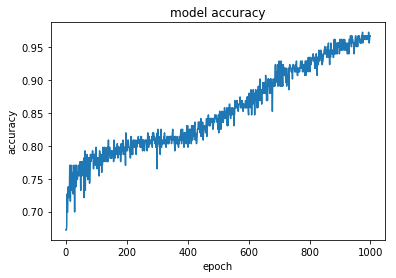

In [80]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

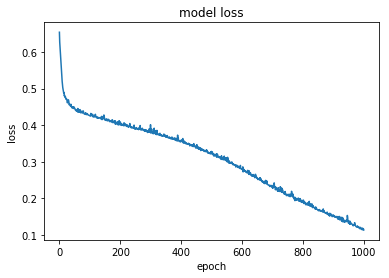

In [81]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

In [ ]:
y_pred = model.predict(data_test_x)

print(accuracy_score(data_test_y, y_pred))
print(confusion_matrix(y_test_encoded, y_pred))
print(classification_report(y_test_encoded, y_pred))

# Entendendo o dataset

Para iniciar, deve-se analisar os atributos de entrada do dataset, seus tipos e o atributo alvo (label/rótulo). Isso pode ser feito através do Pandas, biblioteca de Python específica para análise e preprocessamento de dados. Isso pode ser feito através da biblioteca Pandas, que permite analisar e preprocessar dados. 

In [5]:
# Passo 1 - Leitura do dataset 
train = None
test  = None
# Passo 2 - Separar atributos e classes
X_train = None
y_train = None
X_test =  None
y_test =  None


# Identificando problemas

Mesmo com uma base de dados previamente definida, muitas vezes existem problemas que não foram tratados nela, sendo necessário analisar manualmente. Dentre os problemas, para bases de texto, três são bastante comuns:
* Instâncias com informações faltando (NaN) para determinados atributos
* Dados discrepantes e outliers
* Dados desbalanceados

Dessa forma, deve-se itentificar a presença desses problemas no dataset. 
- Dica 1: utilize funções das bibliotecas do Pandas para os dois primeiros problemas.  
- Dica 2: visualize a distribuição de instâncias por classe através de bibliotecas gráficas de Python (e.g. matplob, seaborn e pyplot).

# Solucionando Problemas

Os problemas podem ser solucionados utilizando algumas medidas estatísticas como média, mediana e moda para substituir as informações que estão faltando e dados discrepantes, ou excluir as instâncias. Além disso, quanto mais balanceado o dataset, menos propensa estará a rede a cometer erros de generalização. A resolução pode ser feita das duas formas utilizando o Pandas. 

# Correlação dos atributos

Uma vez que o dataset foi analisado e possíveis erros foram corrigidos, é importante também verificar a correlação dos atributos. A correlação é uma métrica estatística que mede a associação entre os atributos. Caso existam atributos altamente correlacionados, pode-se excluir alguns deles, permanecendo apenas um dos atributos correlacionados.

Dessa forma, nessa etapa, calcule a correlação entre os atributos. Considere utilizar algumas formas de visualização para melhor interpretação dos resultados.

# Implementando a Rede Neural

Uma vez que a base de dados foi analisada e possíveis problemas foram corrigidos, pode-se implementar a rede neural. Para esse problema, é necessário uma arquitetura multicamada MLP de no máximo 6 camadas escondidas, recomendando-se a implementação das camadas de forma gradual. Da mesma forma, cada camada deverá conter no máximo 30 neurônios. Além disso, recomenda-se a utilização de técnicas de regularização como Dropout, normalização do batch e normalização L2.

Utilize o otimizador de sua escolha para o treinamento por batch, aumente a quantidade de epochs e batch também gradativamente, não é necessário uma quantidade muito alta para resolução do problema. Ao final, mostre a curva de treinamento e a matriz de confusão obtida para o problema. 